### 1. Environment Setup and Hydra Initialization

In [6]:
import torch
from pathlib import Path
from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

# Project-specific imports
from src.data.datamodule import get_dataloader
from src.utils.visualizer import Visualizer
from src.utils.device import get_device

with initialize(version_base=None, config_path="../configs"):
    common_overrides = ["paths.data_dir=../data"]
    
    # Compose and immediately resolve configurations
    cfg_cnn = compose(config_name="main", overrides=["model=spatial_cnn"] + common_overrides)
    cfg_mlp = compose(config_name="main", overrides=["model=pixel_mlp"] + common_overrides)
    OmegaConf.resolve(cfg_cnn)
    OmegaConf.resolve(cfg_mlp)

print(f"Configurations resolved. Data directory set to: {cfg_cnn.paths.data_dir}")

Configurations resolved. Data directory set to: ../data


### 2. Components and Data Loading

In [3]:
# Hardware and Visualization utility setup
device = get_device()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
visualizer = Visualizer(class_names)

# Load a test batch using the resolved configuration
test_loader = get_dataloader(cfg_cnn, train=False)
images, labels = next(iter(test_loader))

print(f"Device: {device} | Batch Loaded: {images.shape}")

Files already downloaded and verified
Device: mps | Batch Loaded: torch.Size([128, 3, 32, 32])


### 3. Loading Pre-trained Models

In [4]:
def load_trained_model(cfg, folder_name):
    """Instantiates a model and loads weights from its final checkpoint."""
    model = instantiate(cfg.model).to(device)
    checkpoint_path = Path(f"../checkpoints/{folder_name}/model_final.pt")
    
    if checkpoint_path.exists():
        state = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(state['model_state_dict'])
        model.eval()
        print(f"Loaded weights for {folder_name}.")
    else:
        print(f"Warning: Checkpoint missing at {checkpoint_path}")
    return model

# Restore both architectures
model_cnn = load_trained_model(cfg_cnn, "SpatialCNN")
model_mlp = load_trained_model(cfg_mlp, "PixelMLP")

Loaded weights for SpatialCNN.
Loaded weights for PixelMLP.


### 4. Qualitative Performance Comparison

Standard Inference: SpatialCNN


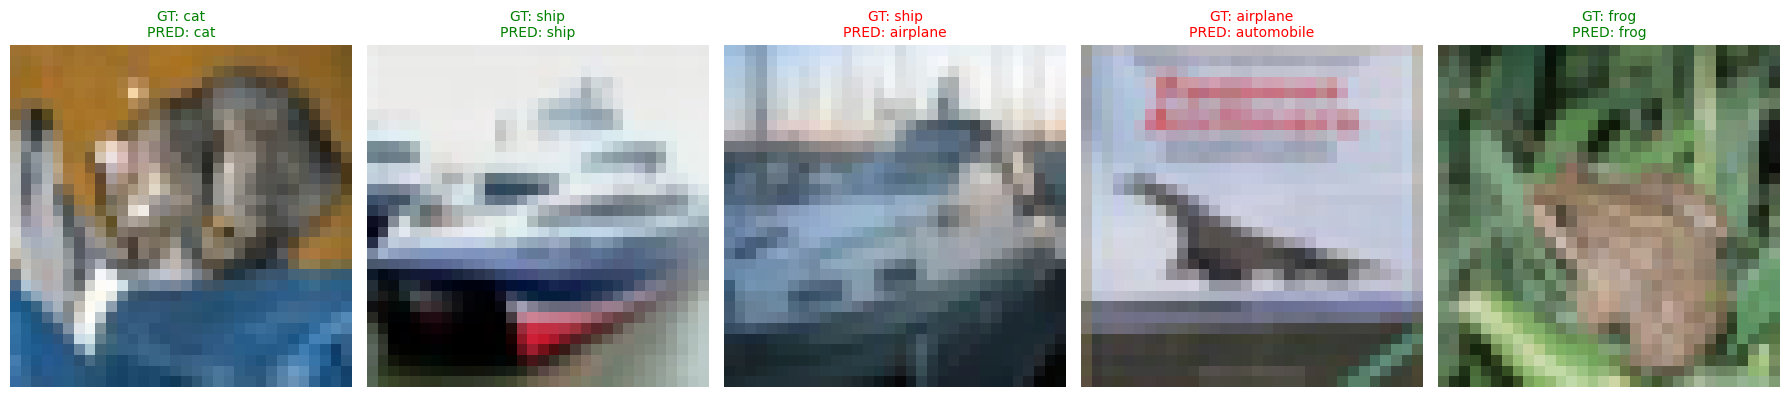


Standard Inference: PixelMLP


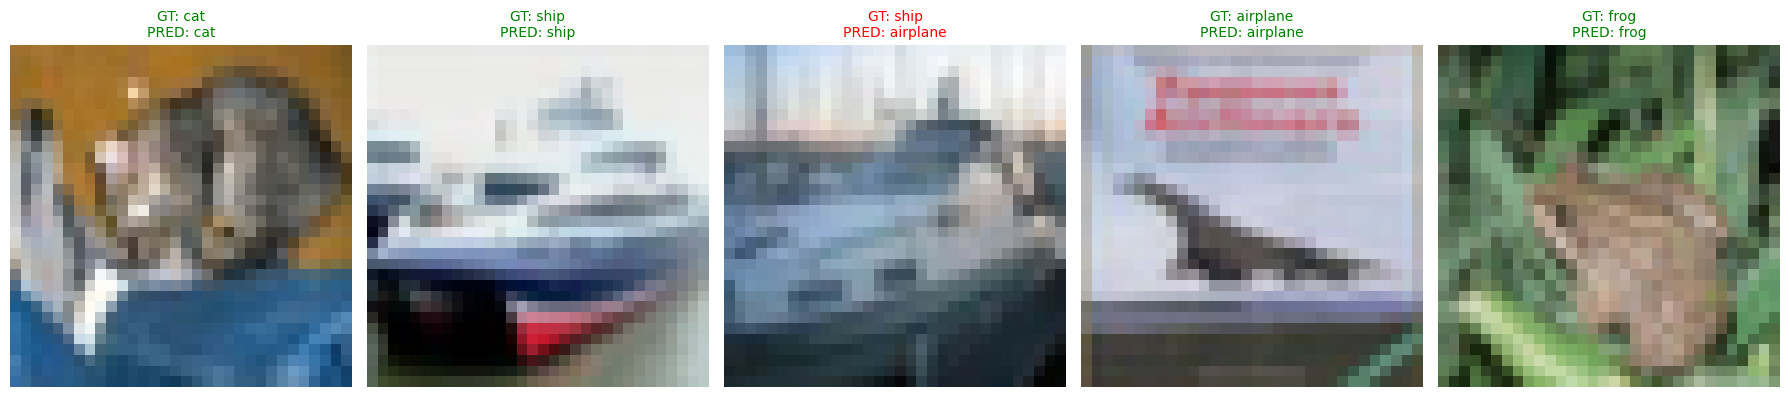

In [8]:
# Run standard inference on a batch of test images
with torch.no_grad():
    preds_cnn = model_cnn(images.to(device)).argmax(dim=1)
    preds_mlp = model_mlp(images.to(device)).argmax(dim=1)

print("Standard Inference: SpatialCNN")
visualizer.plot_predictions(images, labels, preds_cnn, max_imgs=5)
plt.show()

print("\nStandard Inference: PixelMLP")
visualizer.plot_predictions(images, labels, preds_mlp, max_imgs=5)
plt.show()

### 5. Shift Test (Translation Invariance Analysis)

Applying a 5-pixel horizontal shift to test spatial robustness...
Shift Test Result: SpatialCNN (Expected to be robust)


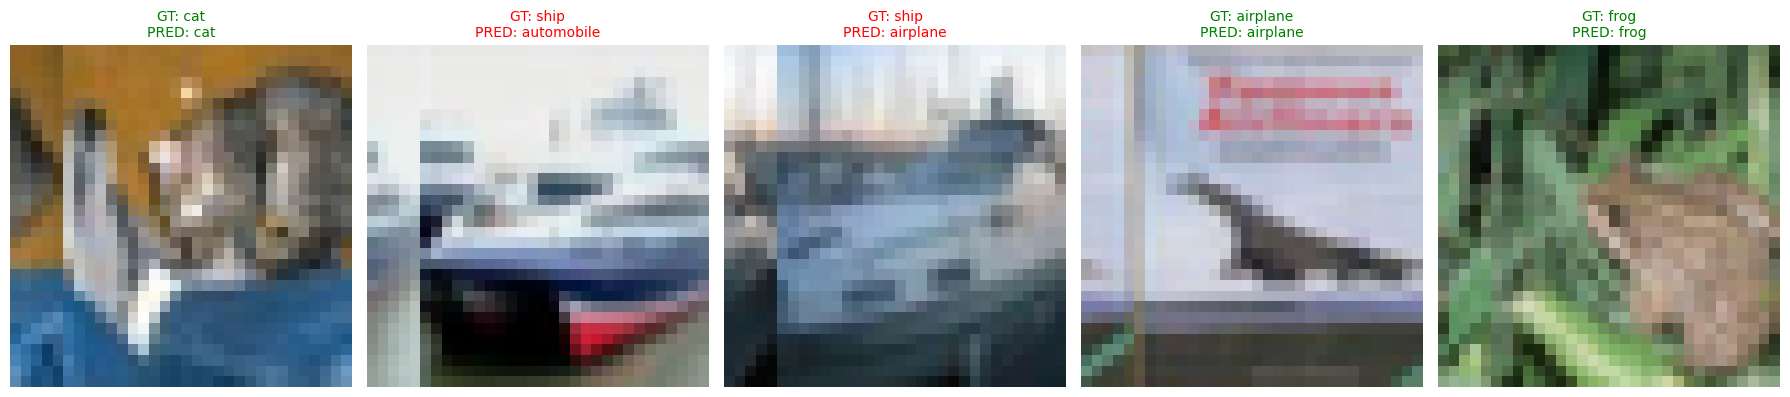


Shift Test Result: PixelMLP (Expected to fail)


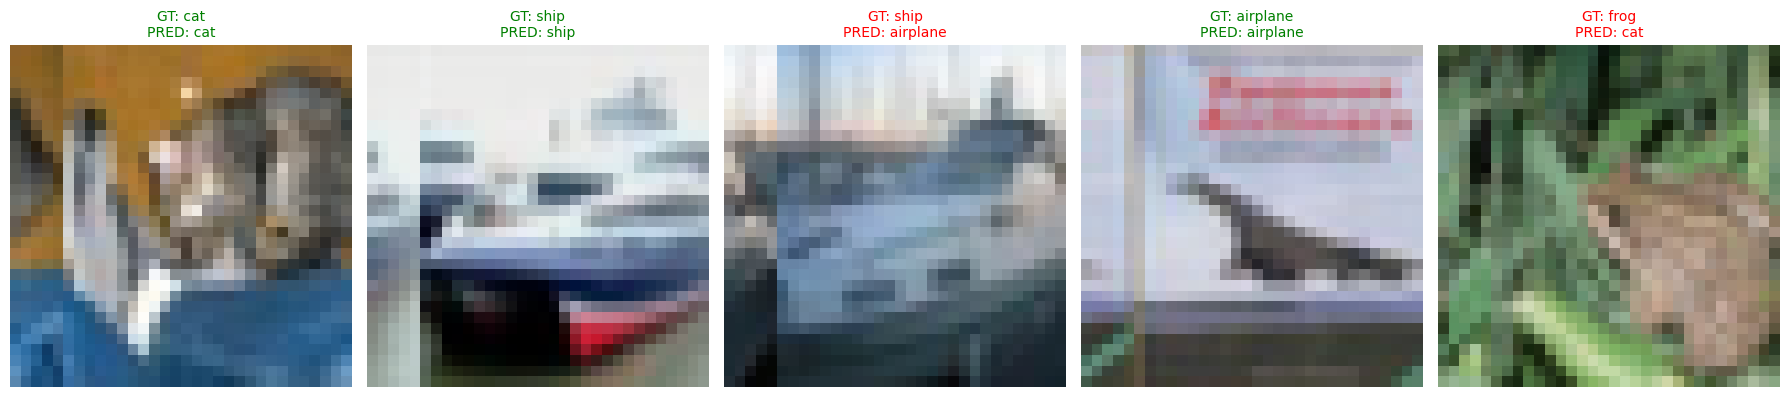

In [9]:
# Apply a spatial shift to simulate real-world variance
# Shifting images by 5 pixels horizontally (dim=3 in NCHW)
pixel_shift = 5
images_shifted = torch.roll(images, shifts=pixel_shift, dims=3)

print(f"Applying a {pixel_shift}-pixel horizontal shift to test spatial robustness...")

with torch.no_grad():
    preds_cnn_shifted = model_cnn(images_shifted.to(device)).argmax(dim=1)
    preds_mlp_shifted = model_mlp(images_shifted.to(device)).argmax(dim=1)

# Visualization of results under stress
print(f"Shift Test Result: SpatialCNN (Expected to be robust)")
visualizer.plot_predictions(images_shifted, labels, preds_cnn_shifted, max_imgs=5)
plt.show()

print(f"\nShift Test Result: PixelMLP (Expected to fail)")
visualizer.plot_predictions(images_shifted, labels, preds_mlp_shifted, max_imgs=5)
plt.show()

### 6. Quantitative Summary 

In [10]:
def get_accuracy(preds, targets):
    return (preds.cpu() == targets.cpu()).float().mean().item() * 100

acc_cnn_orig = get_accuracy(preds_cnn, labels)
acc_mlp_orig = get_accuracy(preds_mlp, labels)

acc_cnn_shifted = get_accuracy(preds_cnn_shifted, labels)
acc_mlp_shifted = get_accuracy(preds_mlp_shifted, labels)

print(f"{'Metric':<20} | {'SpatialCNN':<12} | {'PixelMLP':<12}")
print("-" * 50)
print(f"{'Accuracy (Original)':<20} | {acc_cnn_orig:>10.2f}% | {acc_mlp_orig:>10.2f}%")
print(f"{'Accuracy (Shifted)':<20} | {acc_cnn_shifted:>10.2f}% | {acc_mlp_shifted:>10.2f}%")
print("-" * 50)
print("Conclusion: CNNs maintain higher accuracy under spatial translation compared to MLPs.")

Metric               | SpatialCNN   | PixelMLP    
--------------------------------------------------
Accuracy (Original)  |      80.47% |      71.88%
Accuracy (Shifted)   |      71.09% |      49.22%
--------------------------------------------------
Conclusion: CNNs maintain higher accuracy under spatial translation compared to MLPs.
